<a href="https://colab.research.google.com/github/Martinmbiro/PyTorch-workflow/blob/main/04%20End%20to%20end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Culmination**
> For the sake of practice, I'll train an Artificial Neural Network on a toy dataset (to perform regression), while implementing a few new things.

> Let's get coding then! 💻

In [ ]:
# import necessary libraries
import torch, numpy as np, matplotlib.pyplot as plt, torch.nn as nn
# specify style sheet to use
plt.style.use('fast')
# print pytorch version
torch.__version__

'2.5.1+cu121'

In [ ]:
# setting up device
if torch.cuda.is_available(): # NVIDIA GPU
  device = 'cuda'
elif torch.backends.mps.is_available(): # Apple Silicon GPU
  device = 'mps'
else:
  device = 'cpu' # defauls to cpu

In [ ]:
# check device
device

'cuda'

In [ ]:
# check NVDIA GPU type
!nvidia-smi

Mon Dec 30 19:21:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Create toy dataset
> Using the [`NumPy's`](https://numpy.org/doc/stable/index.html) [`numpy.arange()`](https://numpy.org/doc/stable/reference/generated/numpy.arange.html#numpy-arange) method, we'll create a toy dataset with  
+ `60` features of shape `(60, 2)`
+ `60` targets of shape `(60, 1)`

In [ ]:
# features (X)
X = np.arange(start=1, stop=121, step=1).reshape(-1, 2)
# target (y)
y = np.arange(start=3, stop=240, step=4).reshape(60, -1)

# view shape
X.shape, y.shape

((60, 2), (60, 1))

In [ ]:
# a peek into the data
X[:4], y[:4].squeeze()

(array([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8]]),
 array([ 3,  7, 11, 15]))

#### Turning data into [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html#torch-tensor)
> To turn `ndarray` to `torch.Tensor`, we call the [`torch.from_numpy()`](https://pytorch.org/docs/stable/generated/torch.from_numpy.html#torch.from_numpy) method

In [ ]:
# recall, data is still ndarrays
type(X)

numpy.ndarray

In [ ]:
# turn data into pytorch tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [ ]:
# check to confirm type
type(X)

torch.Tensor

#### Splitting data
> Using [`sklearn's`]() [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#train-test-split) method, we'll split the data in _training-test_ ratio of `80 : 20`

In [ ]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                        test_size=0.2, random_state=42)

# confirm shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([48, 2]),
 torch.Size([48, 1]),
 torch.Size([12, 2]),
 torch.Size([12, 1]))

In [ ]:
# function to plot train and test loss curves
def plot_losses(ep_list:list, train_loss:list, \
                       test_loss:list, best_epoch:None):
  f, ax = plt.subplots(figsize=(5, 3), layout='constrained')

  # train loss
  ax.plot(ep_list, train_loss, label='Training loss',
          linewidth=1.7, color='#00693e')

  # test loss
  ax.plot(ep_list, test_loss, label='Test loss',
          linewidth=1.7, color='#c51e3a')
  # vertical line (for early stopping)
  if best_epoch is not None:
    ax.axvline(best_epoch, linestyle='--', color='#000000', linewidth=1.0,
             label=f'Best ep ({best_epoch})')

  # axis, title
  ax.set_title('Training loss vs Test loss across Epochs',
              weight='black')
  ax.set_ylabel('Loss (Mean Squared Error)')
  ax.set_xlabel('Epoch')
  ax.tick_params(axis='both', labelsize=9)
  plt.grid(color='#dbd7d2')

  # legend
  f.legend(fontsize=9, loc='upper right',
          bbox_to_anchor=(1.28, 0.93),
          fancybox=False)

  plt.show()

### Specifying `Dataset` and `Dataloader`
> ✋ **Info**
+ [`torch.utils.data.TensorDataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) is a utility from [`torch.utils.data`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) module that allows for creation of datasets from multiple tensors
+ [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) combines a dataset and a sampler, and provides an iterable over the given dataset
+ The `batch_size` specified in the `DataLoader` refers to the number of data points considered to calculate the loss value or update weights

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
BATCH_SIZE = 8

# train dataset
train_set = TensorDataset(X_train.to(device), y_train.to(device))
# test dataset
test_set = TensorDataset(X_test.to(device), y_test.to(device))

# train loader
train_ld = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
# test loader
test_ld = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# print values from 1st train batch
a, b = next(iter(train_ld))
print(a)
print(b)

tensor([[ 33.,  34.],
        [ 19.,  20.],
        [  9.,  10.],
        [ 49.,  50.],
        [ 39.,  40.],
        [ 65.,  66.],
        [113., 114.],
        [ 79.,  80.]], device='cuda:0')
tensor([[ 67.],
        [ 39.],
        [ 19.],
        [ 99.],
        [ 79.],
        [131.],
        [227.],
        [159.]], device='cuda:0')


In [ ]:
len(train_ld.dataset)

48

In [ ]:
# length of train batch
len(train_ld)

6

### Build a neural network
> In the previous notebook, we built the layers of our neural network manually. However, we never have to do that unless we're building a complicated network



> 💎 **Pro Tip**  

> For straightforward `forward` computations, we can easily specify the layers and the sequence with which layers are to be stacked using [`nn.Sequential()`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#sequential)

> ✋ **Info**

> Our neural network will consist of 3 [`nn.LinearLayers(in_features, out_features)`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear) and [`nn.ReLu`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#relu) sandwitched between them to introduce non-linearity
+ For out case, the `nn.Linear` accepts a two-dimensional input
and gives an eight-dimensional output for each data point

In [ ]:
torch.manual_seed(42)

# stacking layers in the neural network:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=8),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=1)
).to(device)


#### Visualize model structure
> To do this, we'll use [`torchinfo`](https://github.com/TylerYep/torchinfo)

In [ ]:
# install the library
!pip install torchinfo
# import summary
from torchinfo import summary

In [ ]:
summary(model, input_size=(2,))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1]                       --
├─Linear: 1-1                            [8]                       24
├─ReLU: 1-2                              [8]                       --
├─Linear: 1-3                            [8]                       72
├─ReLU: 1-4                              [8]                       --
├─Linear: 1-5                            [1]                       9
Total params: 105
Trainable params: 105
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Early stopping
> 💎 **Pro Tip**

> _Early stopping_ is a mechanism of stopping training when the validation loss stops improving; with a view to preventing _overfitting_ on the training data
+ Here, we'll create a class to take care of _early-stopping_

In [ ]:
# define a class for early stopping
from copy import deepcopy

class EarlyStopping:
  '''
    patience -> the number of epochs to wait after the last improvement
                before stopping

    counter -> how many epochs have passed since the last improvement

    min_delta -> how much of a difference in loss is to be considered
          worthy to continue training
  '''
  def __init__(self, min_delta:float=0.0, patience:int=5):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_epoch = None
    self.best_loss = None
    self.best_state_dict = None
    self.stop_early = False

  def __call__(self, model:nn.Module, ep:int, ts_loss:float):
    if self.best_epoch is None: # for first time:
      self.best_epoch = ep # store current epoch
      self.best_loss = ts_loss # store current loss as best loss
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())

    # if previous loss - current loss exceeds min_delta:
    elif self.best_loss - ts_loss >= self.min_delta:
      self.best_epoch = ep # store current epoch
      self.best_loss = ts_loss # store current loss as best
      # make a copy of current model's state_dict
      self.best_state_dict = deepcopy(model.state_dict())
      self.counter = 0 # restore counter to zero

    else: # otherwise
      self.counter += 1 # increment counter each time
      if self.counter >= self.patience:
        self.stop_early = True


### Loss function and optimizer
> ✋ **Info**
+ Since this is a regression problem, we'll use [`nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss) as the cost function  
+ Also, we'll use [`torch.optim.SGD`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) as optimizer

In [ ]:
# loss function
loss_fn = nn.L1Loss()
# optimizer

opt = torch.optim.SGD(model.parameters(),
                      lr=0.00035, # learning rate
                      weight_decay=1e-3) # l2 regularization to avoid overfitting


### Model Training
> Here, we'll create an optimization loop

In [ ]:
# initialize empty lists
train_loss, test_loss, ep_list = [], [], []
# epochs
epochs = 21

# initialize early stopping
e_stop = EarlyStopping(patience=10)

In [ ]:
%%time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# training loop
for ep in range(1, epochs):
  # training mode
  model.train()

  tr_loss, ts_loss = [], []

  for x_tr, y_tr in train_ld:
    # zero grad
    opt.zero_grad()
    # forward pass
    tr_preds = model(x_tr)
    # calculate loss
    loss = loss_fn(tr_preds, y_tr)
    tr_loss.append(loss.item())
    # back propagation
    loss.backward()
    # gradient descent
    opt.step()

  # append mean of training loss across all batches
  av_tr_loss = np.mean(tr_loss)
  train_loss.append(av_tr_loss)

  # eval

  model.eval()
  for x_ts, y_ts in test_ld:
    with torch.inference_mode():
      # forward pass
      ts_preds = model(x_ts)
      # calculate loss
      loss = loss_fn(ts_preds, y_ts)
      ts_loss.append(loss.item())

  av_ts_loss = np.mean(ts_loss)
  test_loss.append(av_ts_loss)
  ep_list.append(ep) # append current epoch to list


  # early stopping
  if e_stop.stop_early == False:
    e_stop(model, ep, np.mean(ts_loss))

    '''
    if e_stop.stop_early:
      print(f'\nSTOPPED | BEST Epoch: {e_stop.best_epoch} | Loss: {e_stop.best_loss}\n')
    '''

  print(f'Epoch: {ep} | Train Loss: {av_tr_loss:.2f} | Eval loss: {av_ts_loss:.2f}')

# early stopping
print(f'\nSTOPPED | BEST Epoch: {e_stop.best_epoch} | Loss: {e_stop.best_loss}\n')

Epoch: 1 | Train Loss: 127.05 | Eval loss: 150.92
Epoch: 2 | Train Loss: 120.36 | Eval loss: 143.65
Epoch: 3 | Train Loss: 114.62 | Eval loss: 136.62
Epoch: 4 | Train Loss: 108.56 | Eval loss: 128.46
Epoch: 5 | Train Loss: 101.46 | Eval loss: 118.36
Epoch: 6 | Train Loss: 91.41 | Eval loss: 102.17
Epoch: 7 | Train Loss: 74.75 | Eval loss: 74.23
Epoch: 8 | Train Loss: 45.21 | Eval loss: 22.15
Epoch: 9 | Train Loss: 8.23 | Eval loss: 4.03
Epoch: 10 | Train Loss: 6.38 | Eval loss: 0.61
Epoch: 11 | Train Loss: 5.86 | Eval loss: 10.96
Epoch: 12 | Train Loss: 6.42 | Eval loss: 9.45
Epoch: 13 | Train Loss: 6.68 | Eval loss: 3.41
Epoch: 14 | Train Loss: 5.65 | Eval loss: 13.35
Epoch: 15 | Train Loss: 6.86 | Eval loss: 8.44
Epoch: 16 | Train Loss: 6.45 | Eval loss: 0.82
Epoch: 17 | Train Loss: 6.28 | Eval loss: 1.05
Epoch: 18 | Train Loss: 6.08 | Eval loss: 8.99
Epoch: 19 | Train Loss: 5.76 | Eval loss: 13.92
Epoch: 20 | Train Loss: 7.04 | Eval loss: 6.15

STOPPED | BEST Epoch: 10 | Loss: 0.607

> 📝 **Note**  
> Ideally, _early-stopping_ mechanism should have been placed inside the optimization loop, but since I wasn't training for a lot of epochs; and since this is a simple problem anway, it was placed outside. Besides, it helps in visualization of training progress.
+ The beauty of PyTorch is that it's highly customizable like that

### Model Evaluation
> We'll evaluate the model by plotting loss curves and calculating various evaluation metrics

> ✋ **Info**
+ I'll use [scikit-learn regression metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html#regression-metrics) to evaluate the neural network


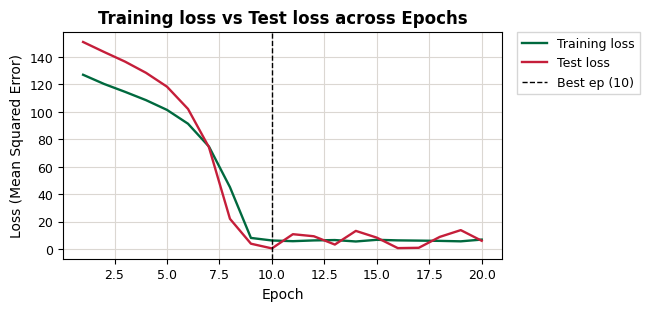

In [ ]:
# plot training losses
plot_losses(ep_list, train_loss, test_loss,
                   best_epoch=e_stop.best_epoch)

#### Rerieving the best model
> We'd saved the best model's `state_dict` inside the `e_stop` object, hence, we can retrieve it and overwrite the original `model` `state_dict` using [`nn.Module.load_state_dict`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.load_state_dict)

In [ ]:
# getting the keys in the state_dict dictionary
e_stop.best_state_dict.keys()

odict_keys(['0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])

In [ ]:
# we'll check for equality for either parameters (just for the sake)
torch.eq(e_stop.best_state_dict['0.weight'], model.state_dict()['0.weight'])

tensor([[False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False],
        [False, False]], device='cuda:0')

In [ ]:
# load state_dict from best model
model.load_state_dict(e_stop.best_state_dict)

<All keys matched successfully>

In [ ]:
# check to confirm
torch.eq(e_stop.best_state_dict['0.weight'], model.state_dict()['0.weight'])

tensor([[True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True],
        [True, True]], device='cuda:0')

In [ ]:
X_test.device

device(type='cpu')

In [ ]:
# get prediction from best model
with torch.inference_mode():
  y_pred = model(X_test.to(device)).cpu().numpy()

#### [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error)

In [ ]:
from sklearn.metrics import mean_squared_error

# calculate
mse = mean_squared_error(y_true=y_test.cpu().numpy(),
                         y_pred=y_pred)
# print
print(f'Mean Squared Error: {mse:.3f}')

Mean Squared Error: 0.401


#### [`root_mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.root_mean_squared_error.html#sklearn.metrics.root_mean_squared_error)

In [ ]:
from sklearn.metrics import mean_absolute_error

# calculate
rmse = mean_absolute_error(y_true=y_test.cpu().numpy(),
                         y_pred=y_pred)
# print
print(f'Mean Absolute Error: {rmse:.3f}')

Mean Absolute Error: 0.583


#### [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score)

In [ ]:
from sklearn.metrics import r2_score

# calculate
r2 = r2_score(y_true=y_test.cpu().numpy(),
                         y_pred=y_pred)
# print
print(f'R2 Score: {r2:.3f}')

R2 Score: 1.000


### Conclusion
> From the evaluation metrics, the model we trained seems to have done incredibly well.

> Where a lower value indicates a better model fit, the model achieved the following scores:
+ `mean_squared_error` = `0.401`
+ `root_mean_squared_error` = `0.633`

> On a scale of `0` -> `1`, the model achieved:
+ `r2_score` = `1.000`

### Saving the model
> We'll also use [`pathlib`](https://docs.python.org/3/library/pathlib.html) - a Python module that provides OOP interface for working with file system paths
> 💎 **Pro Tip**
+ A good practice is to transfer the model to
the CPU before calling torch.save, as this will save tensors as CPU tensors and not as CUDA tensors.
+ This will help in loading the model onto any machine, whether it contains CUDA capabilities or not
+ The [official PyTorch documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference) **recommends** saving and loading a model from the model's [`state_dict`]((https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.state_dict))

In [ ]:
from pathlib import Path

# parent directory
PARENT = Path('models')
PARENT.mkdir(parents=True, exist_ok=True)

# make model path with name
MODEL_NAME = 'regression_model_2_pytorch.pth'
MODEL_PATH = PARENT/MODEL_NAME
# print path
print(MODEL_PATH)

models/regression_model_2_pytorch.pth


In [ ]:
# save model to directory (move it to CPU first)
torch.save(obj=model.to('cpu').state_dict(), f=MODEL_PATH)
print(f'Model successfully saved to: {MODEL_PATH}')

Model successfully saved to: models/regression_model_2_pytorch.pth


> ▶️  **Up Next**
+ Classification (on tabular data) using PyTorch

> Until next time, 👋

